# Heart Disease Database

## Heart disease diagnosis

* The data was collected from the Cleveland Clinic Foundation (the only one that has been used by ML researchers)
* While the databases have $76$ raw attributes (only $14$ of them are actually used)
* The "goal" field refers to the presence of heart disease in the patient (integer valued from $0$ "no presence" to $4$)
* Experiments have concentrated on simply attempting to distinguish presence (values $1,2,3,4$) from absence (value $0$)

## Data Attributes

* All attributes are numeric-valued
* Number of Instances in Cleveland data set: 303
* Number of selected attributes in processed file (only 14 used)
* The names and social security numbers of the patients were replaced with dummy values


    1. age: in years
    2. sex: (1 = male; 0 = female)
    3. cp: chest pain location (1 = substernal; 0 = otherwise)
    4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    5. chol: serum cholestoral in mg/dl
    6. fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    7. restecg: resting electrocardiographic results
        - Value 0: normal
        - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
    8. thalach: maximum heart rate achieved
    9. exang: exercise induced angina (1 = yes; 0 = no)
    10. oldpeak: ST depression induced by exercise relative to rest
    11. slope: the slope of the peak exercise ST segment
        - Value 1: upsloping
        - Value 2: flat
        - Value 3: downsloping
    12. ca: number of major vessels (0-3) colored by flourosopy
    13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
    14. num (the predicted attribute): diagnosis of heart disease (angiographic disease status)
        - Value 0: < 50% diameter narrowing
        - Value 1: > 50% diameter narrowing



In [1]:
# import packages
import numpy as np
import pandas as pd

# set random seed to ensure reproducibility of results
RANDOM_SEED = 42

## Load data and add header (column names)

In [2]:
# Load data file
data_file = "../data/processed.cleveland.data"
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca',
           'thal', 'num']
data_df = pd.read_csv(data_file, sep=',', names=col_names)

print(data_df.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0  


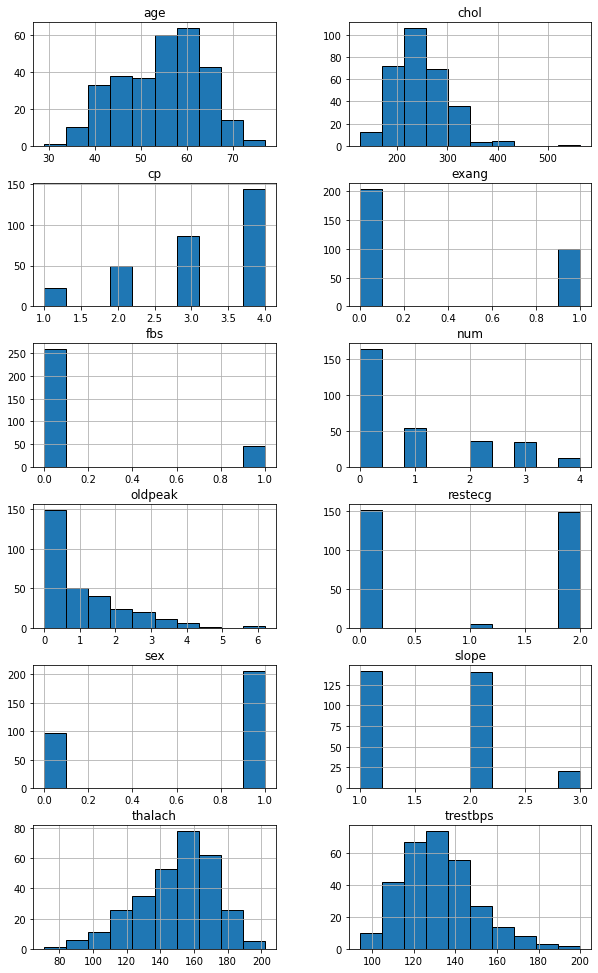

In [3]:
# Check the distribution of each feature in the data by plotting its histogram
data_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');

## Inspect and clean data

* Some of the cell values are missing (value = '?') -> 6 Instances
* Instances with missing attributes are removed (it can be also replaced with the mean value of this attribute from
the training data)

In [4]:
data_clean_df = data_df[~data_df.eq('?').any(1)]    # warning here because of type comparison with a string
# convert all cell values to numeric
data_clean_df = data_clean_df.apply(pd.to_numeric)
# data_clean_df.astype(np.float16)

# sort data by label (num) and age
data_clean_df = data_clean_df.sort_values(['num', 'age'])

print(data_clean_df.head())

      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
132  29.0  1.0  2.0     130.0  204.0  0.0      2.0    202.0    0.0      0.0   
101  34.0  1.0  1.0     118.0  182.0  0.0      2.0    174.0    0.0      0.0   
225  34.0  0.0  2.0     118.0  210.0  0.0      0.0    192.0    0.0      0.7   
117  35.0  0.0  4.0     138.0  183.0  0.0      0.0    182.0    0.0      1.4   
283  35.0  1.0  2.0     122.0  192.0  0.0      0.0    174.0    0.0      0.0   

     slope   ca  thal  num  
132    1.0  0.0   3.0    0  
101    1.0  0.0   3.0    0  
225    1.0  0.0   3.0    0  
117    1.0  0.0   3.0    0  
283    1.0  0.0   3.0    0  


/Users/amiralansary/PycharmProjects/Sensyne_Health_ML_assignment_042020/venv/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


## Data Split

* Split the data into (70%=207) train - (15%=45) validation - (15%=45) test... (another way is to do k-fold)
* The split is stratified on the 14 features to ensure a similar distribution of these features in each subset

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def split_data(indexes, stratified_features, test_size=0.5, k_folds=1, random_state=0):
    """ split the data into two parts
    """
    mskf = MultilabelStratifiedShuffleSplit(n_splits=k_folds,
                                            test_size=test_size,
                                            random_state=random_state)
    # the split return k-fold based on n_splits value
    set1_indexes = [0]*k_folds
    set2_indexes = [0]*k_folds
    fold_idx = 0
    # split the data and generate k-folds
    for set1_fold_index, set2_fold_index in mskf.split(indexes, stratified_features):
        set1_indexes[fold_idx], set2_indexes[fold_idx] = \
            indexes[set1_fold_index], indexes[set2_fold_index]
        fold_idx += 1
    return set1_indexes, set2_indexes

In [6]:
indexes = np.array(data_clean_df.index)
features = data_clean_df.to_numpy()
# split data to train and test
train_indexes, test0_indexes =  split_data(indexes, features, test_size=0.3, k_folds=1, random_state=RANDOM_SEED)
# split test to validation and test
test0_df = data_clean_df.loc[test0_indexes[0]]
valid_indexes, test_indexes =  split_data(np.array(test0_df.index), test0_df.to_numpy(), test_size=0.5, k_folds=1, random_state=RANDOM_SEED)


print('train \n', train_indexes[0])
print('valid \n', valid_indexes[0])
print('test \n', test_indexes[0])

train 
 [132 101 283   3 210  82 222 277  41   4 115 212 220 240 241 295 182 186
 239 255 269 134 178 254  34  85  93 260 263  80 100 125 148 169 197  61
 160 216  86  99 164 238 242  25 198 200  46  59  77  89 122 131 133 139
 253  14  98 112 142 150 176 230  81  88 171  58  63  67 130 167 135 208
   5 215 288 289   7  10 165 202  21  26 144 163  33  43 140 183 149 262
  39  92 129 173 185  20 252  48  51  70  75  27  90 276 152 227 194 258
  42 103 233 257 138 168 268  74  69 237 145  16 232  56  95 214   9  55
 188 111 177  37 107 175 259 278 297 301 157 251 141 172 199 274  54  66
 184 270 224 294  32 143  73 124   2 155 265 272  60 231  12 181 236 246
  68  31  65 158 108 284 114 193   8 119 229   1 245 109  36 120 248 223
 127 235  38 123 300  23  79 206 261 296  97  91 118 154 213  71 170 211
  47 153 146  45 285 264 121  40 136]
valid 
 [ 28 226 281  19 190  84 105 162 221 234 291 102 250 279 244 249   0 203
 218 275 271 256 159  30  57 156  22  62  76 110  72 209 113  52  64  

/Users/amiralansary/PycharmProjects/Sensyne_Health_ML_assignment_042020/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass test_size=0.3, train_size=None, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/amiralansary/PycharmProjects/Sensyne_Health_ML_assignment_042020/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass test_size=0.5, train_size=None, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [7]:
# extract data frames that correspond to the selected indexes
train_df = data_clean_df.loc[train_indexes[0]]
valid_df = data_clean_df.loc[valid_indexes[0]]
test_df = data_clean_df.loc[test_indexes[0]]

print(len(train_df))
print(len(valid_df))
print(len(test_df))

207
45
45


## Data split distribution

* Check distribution is the same between data splits
* The stratification algorithm is expected not to fit to all features, but many of them should've similar distributions

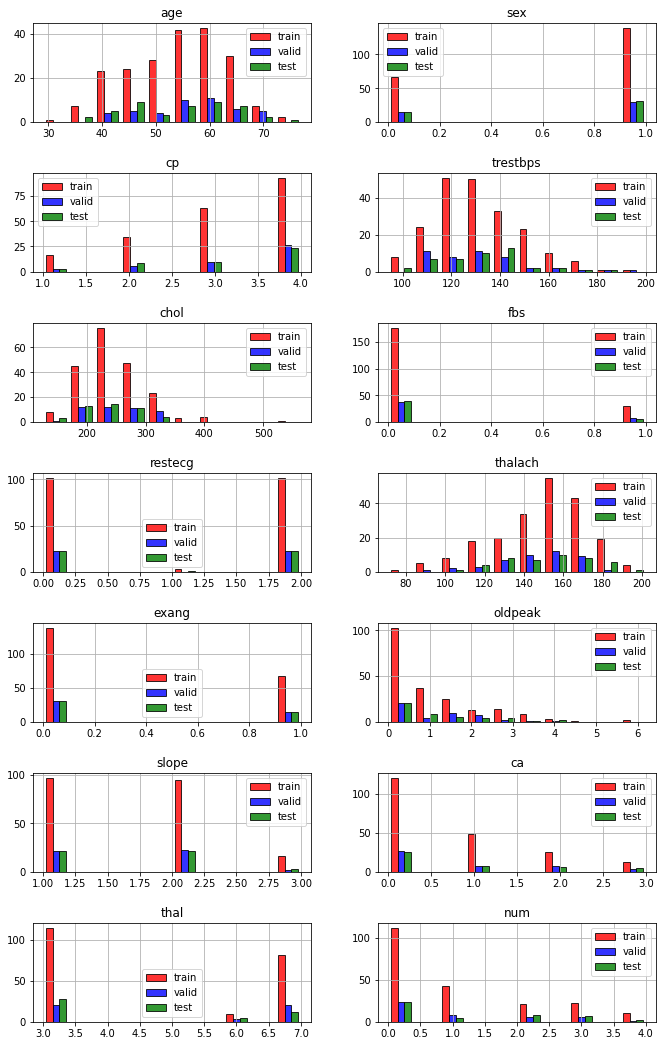

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(7, 2, figsize=(10, 15))
fig.tight_layout(pad=3.0)

axes = ax.flatten()
for feature_i, subplot_i in zip(range(14), axes):
    counts, bins = np.histogram(data_clean_df.iloc[:, feature_i])
    subplot_i.hist([train_df.iloc[:, feature_i], valid_df.iloc[:, feature_i], test_df.iloc[:, feature_i]], bins= bins,
                   color=colors, alpha=0.8, edgecolor='black')
    subplot_i.grid()
    subplot_i.legend(['train', 'valid', 'test'])
    subplot_i.set_title(train_df.columns[feature_i])

# train_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');
# valid_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');
# test_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');

## Normalise data

* Re-scale feature values either to [-1,1] or [0,1] range
* Another way is to standardise the values according to the mean and std of training data

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_normalised_df = train_df.copy()
valid_normalised_df = valid_df.copy()
test_normalised_df = test_df.copy()

# Select from StandardScaler or MinMaxScaler
scaler = MinMaxScaler((-1,1))
train_normalised_df[col_names[:13]] = scaler.fit_transform(train_df.iloc[:, :13].to_numpy())
valid_normalised_df[col_names[:13]] = scaler.transform(valid_df.iloc[:, :13].to_numpy())
test_normalised_df[col_names[:13]] = scaler.transform(test_df.iloc[:, :13].to_numpy())

print(train_normalised_df.head())
print(valid_normalised_df.head())
print(test_normalised_df.head())


          age  sex        cp  trestbps      chol  fbs  restecg   thalach  \
132 -1.000000  1.0 -0.333333 -0.265306 -0.643836 -1.0      1.0  1.000000   
101 -0.787234  1.0 -1.000000 -0.510204 -0.744292 -1.0      1.0  0.572519   
283 -0.744681  1.0 -0.333333 -0.428571 -0.698630 -1.0     -1.0  0.572519   
3   -0.659574  1.0  0.333333 -0.265306 -0.433790 -1.0     -1.0  0.770992   
210 -0.659574 -1.0  0.333333 -0.469388 -0.593607 -1.0     -1.0  0.511450   

     exang   oldpeak  slope   ca  thal  num  
132   -1.0 -1.000000   -1.0 -1.0  -1.0    0  
101   -1.0 -1.000000   -1.0 -1.0  -1.0    0  
283   -1.0 -1.000000   -1.0 -1.0  -1.0    0  
3     -1.0  0.129032    1.0 -1.0  -1.0    0  
210   -1.0 -1.000000   -1.0 -1.0  -1.0    0  
          age  sex        cp  trestbps      chol  fbs  restecg   thalach  \
28  -0.404255  1.0  1.000000  0.142857 -0.447489 -1.0     -1.0  0.526718   
226 -0.234043  1.0  1.000000 -0.632653 -0.643836 -1.0     -1.0  0.099237   
281 -0.234043  1.0  0.333333 -0.265306 

In [11]:
# save files
train_normalised_df.to_csv('../data/train.csv')
valid_normalised_df.to_csv('../data/valid.csv')
test_normalised_df.to_csv('../data/test.csv')

